### Initiation

In [1]:
# To manipulate arrays
import numpy as np 
# To import images 

# To handle track DataFrames
import pandas as pd

# To import images
from skimage import io 
from skimage.io import imread

# For TrackPy
import trackpy as tp

# To make plots
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  

# To work inline; change to %matplotlib notebook for interactive plotting
%matplotlib inline 

# Napari 
%gui qt5 
from skimage import data
import napari

# To create interactive elements
import ipywidgets as widgets 
from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout
from ipywidgets.embed import embed_minimal_html, dependency_state

# Image processing and filters
from skimage.filters import difference_of_gaussians

# Iteration tools such as groupby 
import itertools

# For directories 
import os

# For reloading a library when testing
import importlib

# For deleting/reloading modules in another file for code testing
import sys

# Import trackArrayTools
from trackArrayTools import *


### Set current working directory, track array filenames, and basic parameters

We begin by setting the working directry as well as some key parameters to help us define the track array

In [2]:
# Set the current working directory
os.chdir('C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Lab Management/Dry Lab/Python/Python Scripts/LabScripts/TestData/')

In [3]:
# Enter in the following:
crop_pad = 5    # specifies the size of crops in track arary. If 5, then crops are (2*5 + 1 = 11) x 11
xy_pixel_size = 130   # voxel  xy dimensions in crops
z_pixel_size = 500   # voxel z dimension
video_directory = 'C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Lab Management/Dry Lab/Python/Python Scripts/LabScripts/TestData/'
#video_3D_filename = 'Hela_confocal.tif'
video_3D_filename = 'Gabe_Cell05_good.tif'

With this information, the track array files can now be found. Note the naming convention, assuming original 3D movie is named "original_movie.tif": 

1. 3D video : "original_movie.tif" 
2. track array tracks : "Spots in tracks statistics_original_movie.csv"
3. track array video : "Spots in tracks statistics_original_movie_crop_pad_n.tif" where n is the crop_pad size (an integer)

In [4]:
#  Track array filenames should be the following:
track_array_filename = 'Tracks_' + video_3D_filename[:-4] + '_crop_pad_' + str(crop_pad) + '.tif' 
track_filename = track_array_filename[:-15] + '.csv'

# For display, so z and xy are shown properly when viewing track array
z_renorm = z_pixel_size/xy_pixel_size  

### Read in sample track array tif and csv file to create object from TrackArray class

If the track array tif video has not been made, then the following line of code should be run. This only needs to be done once. In principle, I imagine this bit of code to be in a separate file. The idea would be to take your data, track it, and then immediately run this code to make a track array tif video. All subsequent analysis can then be done on the track array tif video, without requiring the large, original 3D video file.   

In [5]:
# Create track array tif video from the original 3D video
# This only needs to be done once. Thereafter, can skip and just work with track array itself
#create_track_array_video(video_directory, video_3D_filename, track_filename, crop_pad, xy_pixel_size, z_pixel_size)

In [135]:
dims = list(track_array_vid.shape)
[track_array_vid.shape, np.moveaxis(track_array_vid,0,-1).shape]

[(11, 1309, 550, 2), (1309, 550, 2, 11)]

In [7]:
# Read in the track array video and the tracks files:
track_array_vid = imread(video_directory + track_array_filename)  # Read in track array .tif file
track_array_df = pd.read_csv(video_directory + track_filename) # Read in tracks are read in as "dataframes (df)"
# Make sure track array video channels dimension is listed last
dims = list(track_array_vid.shape)
if len(dims) != 3:     # check if just a single channel video
    n_channels = min(dims)
    n_channels_index = dims.index(n_channels)
    track_array_vid = np.moveaxis(track_array_vid,n_channels_index,-1)

Once the track array tif video is created, then we can create the TrackArray object, which will link the track array tif video and the corresponding track array file. Here I name the TrackArray object ta. This could be anything, but by convention we keep it simple. If you are working with more than one track array object, you could call them ta1, ta2, ..., for example. Or it is possible to even make a list of track array objects, etc.

In [8]:
# Create a track array object:
#del sys.modules['trackArrayTools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
#from trackArrayTools import *
ta = TrackArray(track_array_vid, track_array_df, crop_pad)

### Summary of  methods in the track array class

Having created a track array object, you can now run many useful methods (i.e., functions). To explore these methods, you can type 'ta.' and then hit the tab key. This will show all the possible functions that can now be run. If you need help on how to use a specific function, choose that function and the hit "shift + tab." That will give the basic help information about the function, along with the expected arguments. We'll begin with the basic functions:

First Access the inputted parameters used to make the track arary
1. 'ta.arr' is the numpy array of intensity values. It has dimensions z_slice x (n_tracks x crop_dim) x (t x crop_dim), where crop_dim = 2 *crop_pad + 1. You can append a .shape at the end to see the dimensions of the array. 

In [8]:
ta.arr.shape

(11, 1309, 550, 2)

2. 'ta.df' is the dataframe containing all the track information. It can have an arbitrary number of columns, but minimally must have a 'TRACK_ID', 'POSITION_T', 'POSITION_Z', 'POSITION_Y', and 'POSITION_X'

In [ ]:
ta.df.head() # I use the .head() command to just show the first four rows

3. 'ta.crop_pad' gives the crop_pad size

In [ ]:
ta.crop_pad

Beyond these basic attributes that were used to create the track array, there are many other useful functions for track arrays. To access these you need to type 'ta.function_name()' with the '()' on the end. For some of the functions no input is needed, in which case 'ta.function_name()' is sufficient. In other cases when inputs are needed, you would type something like 'ta.function_name(input1, input2, ...)'. Again, by typing ta.function_name and then hitting 'shift + tab', you'll get 'help' info on the function so you can see how many and what types of inputs are needed. 

To illustrate, here are some basic parameters about the track array you can access. I've surrounded this by square brackets '[... ]' to make a list (the equivalent of curly brackets in mathematica. This is just a convenient way to run multiple bits of code in a single line.

In [ ]:
[ta.n_channels(), ta.z_slices(), ta.crop_dim(), ta.n_tracks()]

To get a listing of all the unique track IDs that make up the track array use the following:

In [ ]:
ta.track_IDs()

Notice this returns a numpy array. Notice also the size of this array matches the number of tracks in the track array:

In [ ]:
[ta.track_IDs().size, ta.n_tracks()]

To get access to each individual 3D crop in the track array, use the following:

In [ ]:
ta.crops().shape

In this form, crops are indexed by track number and time. For example, to access the crop corresponding to the second track at the 3rd timepoint use ta.crop()[2,3]. Using the '.shape' command again, we can confirm this has the dimensions we would expect of a single crop:

In [ ]:
ta.crops()[2,3].shape

The crop has dimensions 7 (z-slice) x 11 (x dimension) x 11 (y dimension) x 3 (color channels). You can get just channel 1 using the following (notice indexing in python starts from 0):

In [ ]:
ta.crops()[2,3,:,:,:,0].shape

As a final simple function, often we want to know the range of intensity values in our track arrays. This can be achieved using ta.int_range(a,b), where a and be are ranges expressed in units of standard deviation about the mean. Thus, if you want to find the range of intensities that are 1 standard deviation to the left of the man and 5 standard deviations to the right of the mean, you would use ta.int_range(1,5):

In [ ]:
ta.int_range(1, 9)

Notice this returned a list of pairs, where each pair corresponds to the max and min intensity within the inputted range and the list goes over the channels. Since ta.arr has 3 channels, three pairs are returned. 

Finally, to view the track array, use ta.napari_viewer(ta.arr, scale), where scale is a list of the relative xyz voxel dimensions. For example, [1,1,1] would be x, y, and z voxels all the same size. [z_renorm = z_pixel_size/xy_pixel_size, 1,1] yields images with voxels that match the microscope. We can also include specify the int_range, in which case it is convenient to use our built-in int_range(a,b) function described above:

In [ ]:
ta.napari_viewer(ta.arr, [z_renorm,1,1], int_range = ta.int_range(0.1,8))

There are two additional optional arguments for the napari_viewer() method, 'label' and 'layer'. The optional label = "" argument allows you to see the track_ids next to the track array during visualization. To generate this label, which takes the form of a dataframe, we use the track_label() command:

In [19]:
ta.track_ID_markers().head()

,TRACK_ID,POSITION_T,POSITION_Z,POSITION_Y,POSITION_X
0,0.0,0.0,0.0,5.0,0.0
1,1.0,0.0,0.0,16.0,0.0
2,2.0,0.0,0.0,27.0,0.0
3,3.0,0.0,0.0,38.0,0.0
4,4.0,0.0,0.0,49.0,0.0


To use it with the napari_viewer() function, type the following and then, when the napari window opens, select the 'show ID' checkbox. This will show the track_ID next to each track, which is useful for quickly reviewing tracks and taking notes.

In [ ]:
ta.napari_viewer(ta.arr, [z_renorm,1,1],markers=ta.track_ID_markers(),int_range = ta.int_range(0.1,8))

As for the optional layer = "" argument, we'll discuss that in more detail futher below. Briefly, it allows you to add additional channels or layers to your image.  

One nice feature of the track array object is that it is modular by nature. This allows us to construct methods that work on individual crops. This concept significantly simplifies future method construction and analyses. To illustrate, I have made a method that works on an individual crops titled: best_z(crop). The method, along with all the others, can be found in the trackArrayTools.py file. This method returns the z-slice (an integer) in which it predicts the tracked particle to be found within the inputted crop. This is achieved by finding the z-slice with the maximal mean intensity within a central 3x3 xy square. For example:

In [ ]:
ta.best_z(ta.crops()[1,10,:,:,:,0]) 

Once such a function exists to work on a single crop, it is straight-forward to iterate it across the entire track array. For example, it is often desirable to create a mask that highlights just the best-z planes. This is achieved by iterating the best_z() function across the track array. I used this concept to create another function called 'z-masks(r,ch)' that returns a binarized sets of masks with 1s in the best z-slices (+/- r) for each crop in the track array. The 'ch' input variable allows you to choose which channel you want to use as the basis for making this mask. To illustrate, to make a mask highlighting the best z-slice +/- 1 as determined from the first (mRNA) channel (ch = 0), use the following command:

In [ ]:
ta.z_masks(1,0).shape

The dimensions of this array match those of ta.crops(), with the exception that the mask is a single channel array:

In [ ]:
[ta.z_masks(1,0).shape, ta.crops().shape]

We can visualize this mask on top of the original image using the optional 'layer = ...' argument in the napari_viewer() function: 

In [ ]:
ta.napari_viewer(ta.crops(),[z_renorm,1,1],layer=ta.z_masks(1,0))

Often, we want to see all the crops together, as in the original crop array. This is achieved with the to_array(crops) method. This method produces an array that matches the orginal ta.arr track array:

In [ ]:
[ta.to_crop_array(ta.z_masks(1,0)).shape, ta.arr.shape]

In this way, all masks and crops can be viewed and checked at once:

In [ ]:
ta.napari_viewer(ta.arr, [z_renorm,1,1],layer=ta.to_crop_array(ta.z_masks(1,0)))

With the ability to make masks that match the dimension of either the original track array (ta.arr) or the track array crops (ta.crops()), the mask can simply be multiplied by the array to create images with data just in the mask. For example, to create a best-z projection, you could just multiple ta.crops() by ta.z_masks(1,0). Then, doing a max projection on that would create a "smart-projection" 2D image, where only the best z-planes are shown. Since projecting over masks in this way is common, I created a function that does it called mask_projection(mask_array). The only input is the array of masks you want to project over. For example ta.to_crop_array(ta.z_masks(1,0)):

In [136]:
ta.napari_viewer(ta.mask_projection(ta.to_crop_array(ta.z_masks(1,0))), [1,1], markers = ta.track_ID_markers())

Beside the best-z mask, we can make all kinds of masks. I've created two others that are 3D extensions of the disk and donut masks we use to quantify signal and background from 2D crops: (1) cigar_masks(rx, ry, rz) produces an ellipsoidal binarized mask with axes rx, ry, and rz that is centered on the tracked particle in each crop (again using the best-z(crop) method to determine the optimal z-coordinate); (2) capsule_masks(rx,ry,rz) produces a one-voxel thick capsule that surrounds and is seperated from the corresponsding cigar mask by one pixel. Using these two functions, we can quantify signal and background intensities for each tracked particle in the track array. 

In [9]:
# Make cigar-capusle masks for intensity quantification
cigar_masks = ta.cigar_masks(3,3,2)  # make cigar masks centered on tracked x and y and best-z
capsule_masks = ta.capsule_masks(3,3,2)  # make capsule masks centered on tracked x and y and best-z 

We can visualize these as a layer in the original track array to make sure it works. Notice the beauty of these masks is they allow the capsule or cigar to be cut in half if the spot is at the top or bottom of a crop. 

In [138]:
# scroll through all crops to check cigar_masks
ta.napari_viewer(ta.arr,[z_renorm,1,1],layer= ta.to_crop_array(cigar_masks),int_range=ta.int_range(.3,8)) 

With these masks in hand, it is easy to make quantitative measurements. We simply multiply the mask by the original track array and find the average intensity, ignoring zeros. One minor issue is that to multiply the mask by the track array, you need to make them have exactly the same dimensions. As is, the masks do not have color channels, so they don't quite have the same dimensions:

In [11]:
[cigar_masks.shape, ta.crops().shape]

[(119, 50, 11, 11, 11), (119, 50, 11, 11, 11, 2)]

Thus, I create a method called to_color_mask(mask) that just stacks the masks to make a color version with the same number of color channels as the track array. 

In [12]:
[ta.to_color_mask(cigar_masks).shape, ta.crops().shape]

[(119, 50, 11, 11, 11, 2), (119, 50, 11, 11, 11, 2)]

Now these two arrays can be multiplied together to quantify signals inside cigars and capsules (the 3D version of disks and donuts). Since the masks have a value of 1 inside the cigars/capsules and zeros everywehre else, this multiplication results in lots of zeros. We want to ignore these zeros and then calculate the mean intensity from all the non-zero values. To do this, we use the numpy command np.ma.masked_equal(array, val). This command basically tells the computer to ignore all array elements with value val. If we set val = 0, we ignore zeros. Afterwards, we can calculate means, maxs, and medians from the array and be confident the zeros do not contribute to the calculations. 

Putting it together, we can determine the intensity inside each crop with relatively little code:

In [10]:
# To multiply masks by crops, they should have n_channels like crops. 
my_signal = np.mean(np.ma.masked_equal(ta.to_color_mask(cigar_masks)*ta.crops(),0),axis=(2,3,4)) # Mean on Masked crops ignores zeros
my_background = np.mean(np.ma.masked_equal( ta.to_color_mask(capsule_masks)*ta.crops(),0),axis=(2,3,4)) # Mean on Masked crops ignores zeros
my_intensity = my_signal.data - my_background.data  # get unmasked data out of masked array

Notice my_intensity is also an array, but now an array of intensity values for each channel. There are ta.n_tracks() rows, ta.n_frames() columns, and n_channels channels:  

In [11]:
[my_intensity.shape, ta.n_tracks(), ta.n_frames(), ta.n_channels()]

[(119, 50, 2), 119, 50, 2]

Now we can scan through the intensity vs time data in a fairly straight-forward way:

In [22]:
# def myIntPlotter(myTOI):
#     t = np.arange(ta.n_frames())
#     r = np.ma.masked_equal(my_intensity[myTOI,:,0],0)  # Red channel; mask zeros (skipped frames in tracks)
#     g = np.ma.masked_equal(my_intensity[myTOI,:,1],0) #np.ma.masked_equal(myInt[myTOI,:,1],0)  # Green channel; mask zeros
# #    b = np.ma.masked_equal(my_intensity[myTOI,:,2],0) #np.ma.masked_equal(myInt[myTOI,:,2],0)  # Blue channel; mask zeros
#     fig, ax = plt.subplots()
#     ax.plot(t, r,'ro-',g,'gs-')
#     ax.set(xlabel='frame #', ylabel='Intensity (a.u.)',
#        title='Track Intensity vs. time')
#     ax.grid()
#     plt.ylim(-300, 1000)
#     plt.show()
#     print("TrackMate ID is %d." % ta.track_IDs()[myTOI])
# interact(myIntPlotter, myTOI=(0,my_intensity.shape[0]-1,1))

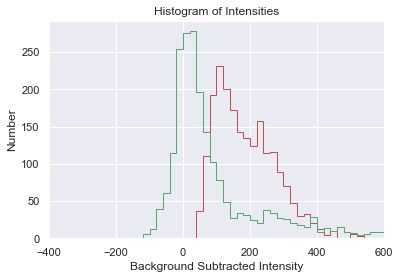

In [12]:
# the histogram of the data
allr = np.ma.masked_equal(my_intensity[:,:,0],0).compressed().flatten() # Drop zeros
allg = np.ma.masked_equal(my_intensity[:,:,1],0).compressed().flatten() # Drop zeros
#allb = np.ma.masked_equal(my_intensity[:,:,2],0).compressed().flatten() # Drop zeros
n, bins, patches = plt.hist(allr, 50, (-400, 600),edgecolor='r',histtype='step')
n, bins, patches = plt.hist(allg, 50, (-400, 600), edgecolor='g', histtype='step')
#n, bins, patches = plt.hist(allb, 50,(-400, 600), edgecolor='b',histtype='step')
plt.xlabel('Background Subtracted Intensity')
plt.ylabel('Number')
plt.title('Histogram of Intensities')
plt.grid(True)
plt.xlim(-400, 600)
plt.show()

One way to determine if a spot is translating or not is to find out how many times it is above a certain intensity threshhold, say int_th = 50, in the translation channel. A true translation spot should be above int_th = 50 for a minimal number of consecutive frames, say run_length = 4. A method that determines which tracks satisfy this condition is find_translating_spots(my_intensity, int_th, run_length): 

In [139]:
translating_spots, translating_spots_index = ta.find_translating_spots(my_intensity[:,:,1],90,4)
[translating_spots, translating_spots_index]

[array([  2,  13,  18,  19,  25,  31,  32,  38, 110, 139, 171, 180, 202,
        205, 212, 226, 227, 239, 266, 273], dtype=int64),
 array([  2,  10,  13,  14,  19,  24,  25,  30,  58,  64,  73,  78,  88,
         90,  93,  97,  98, 104, 114, 118], dtype=int64)]

Now we can make a new track array that includes just these tracks. Notice here I'm using built-in numpy and panda functionality to create the sub-arrays and sub-tracks.

In [14]:
# Make a track array for translating spots
ta_trnl = TrackArray(ta.to_crop_array(ta.crops()[translating_spots_index]), ta.df[ta.df['TRACK_ID'].isin(translating_spots)], ta.crop_pad)

All the functions we used above can now be done with this new track array using ta_trnl.method_name(...). For example, we can now easily view the best-z projection of these tracks using just a minimal amount of code:

In [143]:
# view best-Z max projection, i.e., "smart-Z projection"
ta_trnl.napari_viewer(ta_trnl.mask_projection(ta_trnl.to_crop_array(ta_trnl.z_masks(1,0))),
                      [1,1],markers=ta_trnl.track_ID_markers(),int_range=ta_trnl.int_range(.3,9))

In [142]:
ta_trnl.napari_viewer(ta_trnl.crops(),[z_renorm,1,1],int_range=ta_trnl.int_range(0.3,9))

In [48]:
# def myIntPlotter(myI):
#     myTOI = translating_spots_index[myI]
#     t = np.arange(ta_trnl.n_frames())
#     r = np.ma.masked_equal(my_intensity[myTOI,:,0],0)  # Red channel; mask zeros (skipped frames in tracks)
#     g = np.ma.masked_equal(my_intensity[myTOI,:,1],0) #np.ma.masked_equal(myInt[myTOI,:,1],0)  # Green channel; mask zeros
# #    b = np.ma.masked_equal(my_intensity[myTOI,:,2],0) #np.ma.masked_equal(myInt[myTOI,:,2],0)  # Blue channel; mask zeros
#     fig, ax = plt.subplots()
#     ax.plot(t, r,'ro-',g,'gs-')
#     ax.set(xlabel='frame #', ylabel='Intensity (a.u.)',
#        title='Track Intensity vs. time')
#     ax.grid()
#     plt.ylim(-300, 1000)
#     plt.show()
#     print("TrackMate ID is %d." % ta.track_IDs()[myTOI])
# interact(myIntPlotter, myI=(0,len(translating_spots_index)-1,1))

In [144]:
z_masks = ta_trnl.z_masks(1,0)  # make masks for all track array crops corresponding to best-z slice +/- 1
kymographs = np.amax(ta_trnl.to_color_mask(z_masks)*ta_trnl.crops(),2) # multiply color mask by crops and max-project z to get X x Y x T 
ta_trnl.napari_viewer(kymographs,[1,1,1],int_range=ta_trnl.int_range(.3,15)) 

In [44]:
ta_trnl.n_tracks()/ta.n_tracks()

0.16806722689075632

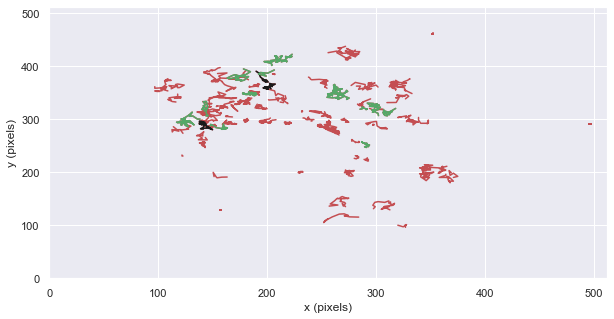

In [132]:
plt.figure(figsize=(10,5))
for i in ta.track_IDs():
    x, y = ta.df[ta.df['TRACK_ID']==i][['POSITION_X','POSITION_Y']].T.values
    plt.plot(x, y,'r')
    plt.xlabel('x (pixels)')
    plt.ylabel('y (pixels)')
plt.ylim(0, 512)
plt.xlim(0, 512)
for i in translating_spots:
    x, y = ta_trnl.df[ta_trnl.df['TRACK_ID']==i][['POSITION_X','POSITION_Y']].T.values
    if i == 110 or i == 32 or i == 13:
        plt.plot(x,y,'k')
    else:
        plt.plot(x, y, 'g')
    plt.xlabel('x (pixels)')
    plt.ylabel('y (pixels)')

(0.0, 512.0)

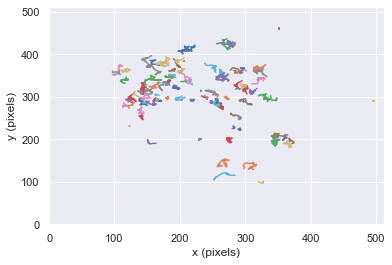

In [93]:
for i in ta.track_IDs():
    x, y = ta.df[ta.df['TRACK_ID']==i][['POSITION_X','POSITION_Y']].T.values
    plt.plot(x, y)
    plt.xlabel('x (pixels)')
    plt.ylabel('y (pixels)')
plt.ylim(0, 512)
plt.xlim(0, 512)

In [65]:
#ta_trnl.df[ta_trnl.df['TRACK_ID'==translating_spots[0]]][['POSITION_Y','POSITION_X']]

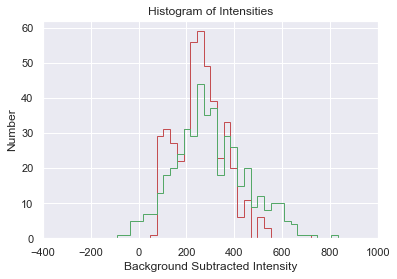

In [15]:
# the histogram of the data
allr = np.ma.masked_equal(my_intensity[translating_spots_index,:,0],0).compressed().flatten() # Drop zeros
allg = np.ma.masked_equal(my_intensity[translating_spots_index,:,1],0).compressed().flatten() # Drop zeros
#allb = np.ma.masked_equal(my_intensity[:,:,2],0).compressed().flatten() # Drop zeros
n, bins, patches = plt.hist(allr, 50, (-400, 1000),edgecolor='r',histtype='step')
n, bins, patches = plt.hist(allg, 50, (-400, 1000), edgecolor='g', histtype='step')
#n, bins, patches = plt.hist(allb, 50,(-400, 600), edgecolor='b',histtype='step')
plt.xlabel('Background Subtracted Intensity')
plt.ylabel('Number')
plt.title('Histogram of Intensities')
plt.grid(True)
plt.xlim(-400, 1000)
plt.show()

That pretty much summarizes what can currently be done with track array objects. There are a few more useful commands for visualization described below. There are lots of new commands we could now make. Some ideas include:

1. A method that saves arrays as 'tif' images. Would be useful to save 2D smart-projection track arrays. This method would also be useful to save a .tif showing just the translating spots. How to include the track_ids here? Should make another method to save track files with proper naming conventions.  

2. A method that categorizes individual crops based on whether or not there are detectable particles in each channel. This could use the built-in functionality of PyTrack (see below).

3. A method that determines the instantaneous velocity of each crop (by checking how much it moved in the previous frame). This information could then be performed on all crops in the track array to generate a new layer that is color-coded to indicate mobility (darker would be less mobile than brighter, for example). 

4. A method that determines a best_x, best_y, and best_z for all channels in an individual crop. This could be used to create better masks for quantification in different channels. Currently we assume all channels are well aligned and that green translation spots will be right on top of red mRNA spots.

5. A method that improves upon the cigar_masks() method to create the tightest possible mask that includes all signal. Basically, starting from a bandpass-filtered crop as a starting point, the algorithm would try a range of intensity thresshold values to binarize the crop. It would then identify the single largest connected component at each threshhold value that has xy coordinates approximately centered. If there is a real particle, the size of this connected component should remain fairly flat over some range of threshhold values. If such a flat range is observed, this connected component should make a reasonable and relatively tight mask. The mask could then be dilated to create a corresponding capsule mask. 

6. The TrackArray object needs to be extended to ParticleArray, to examine movies where particles cannot be tracked, but their intensities still give information. In particular, I'm thinking about Harringtonin experiments, where particles are not tracked, but the average intensity of all particles at each time point should decrease over time. I'm thinking our TrackArray shows all tracks vertically, with time horizontal. With a ParticleArray, we could keep time horizontal, but each row of crops would no longer correspond to a single track, but rather a group of disconnected particles from frame to frame. 

7. A function to combine track array rows? Sometimes it is obvious two tracks are same. 

### Demonstrating a few more useful methods for visualizing track arrays in unique ways

In [ ]:
# Find best-Z slices and make best-Z max projection
z_masks = ta.z_masks(1)  # make masks for all track array crops corresponding to best-z slice +/- 1
z_mask_array = ta.to_crop_array(z_masks)  # convert to array of masks (T x crop_pad) x (N x crop_pad)
best_z_projection = ta.best_z_projection(z_mask_array)  # make a max-z projection of best-z planes
kymographs = np.amax(ta.to_color_mask(z_masks)*ta.crops(),2) # multiply color mask by crops and max-project z to get X x Y x T 
[z_masks.shape, z_mask_array.shape, best_z_projection.shape, kymographs.shape]

In [ ]:
# # scroll through all crops to check z_masks
# ta.napari_viewer(ta.crops(),[z_renorm,1,1],layer=z_masks,int_range=ta.int_range(.3,8)) 

In [ ]:
# # view z_mask_array with track array 
# ta.napari_viewer(ta.arr,[z_renorm,1,1],label=ta.track_ID_markers(),layer=z_mask_array,int_range=ta.int_range(.3,8))

In [ ]:
# # view best-Z max projection, i.e., "smart-Z projection"
# ta.napari_viewer(best_z_projection,[1,1],label=ta.track_ID_markers(),int_range=ta.int_range(.3,9))

In [ ]:
# # scroll time through a crop array with dimensions (N x crop_pad) x (Z x crop_pad)
# ta.napari_viewer(ta.to_crop_array_NxZ(ta.crops()),[1,1,1],
#                  layer=ta.to_crop_array_NxZ(z_masks),label=ta.track_ID_markers(),int_range=ta.int_range(.3,8)) 

In [ ]:
# # scroll through all kymographas
#ta.napari_viewer(kymographs,[1,1,1],int_range=ta.int_range(.3,8)) 

### Detecting spots in other channels using PyTrack

The following uses Pytrack (import trackpy as tp). See http://soft-matter.github.io/trackpy/v0.4.2/ for documentation and tutorials. 

To find the particles in a single crop use the following. Note diameter specifies expected size of particles, i.e. voxel dimensions in xyz. (3,5,5) would correspond to particles spanning 3 z-slices and 5 pixels in x and y.

In [16]:
tp.locate(ta.crops()[9,2,:,:,:,0], diameter=(3, 5, 5))

,z,y,x,mass,size_z,size_y,size_x,ecc,signal,raw_mass,ep_z,ep_y,ep_x
0,7.908976,5.076485,4.247788,631.30298,0.603404,1.423791,1.219314,NaN,101.758698,22107.0,0.033784,0.089384,0.089384


This can be performed on an entire track using batch processing. For example, to get all particles in track corresponding to TRACK_ID = 17, type:

In [25]:
toi = ta.track_IDs().tolist().index(110)
features = tp.batch(ta.crops()[toi,:,:,:,:,0], diameter=(3, 5, 5))
features['z_renorm'] = features['z']*z_renorm
features_trnl = tp.batch(ta.crops()[toi,:,:,:,:,1], diameter=(3, 5, 5))
features_trnl['z_renorm'] = features['z']*z_renorm
features.head()

Frame 49: 1 features


,z,y,x,mass,size_z,size_y,size_x,ecc,signal,raw_mass,ep_z,ep_y,ep_x,frame,z_renorm
0,6.003977,5.089773,4.935795,1948.627989,0.709113,1.242706,1.328234,NaN,282.329623,32436.0,0.009792,0.025907,0.025907,12,23.092220
1,5.985765,5.230808,5.154550,1738.467844,0.724332,1.422100,1.261853,NaN,225.373310,30111.0,0.011268,0.029813,0.029813,13,23.022174
2,6.019813,4.905889,5.111172,1567.892420,0.740376,1.251746,1.357423,NaN,219.177036,28073.0,0.012309,0.032567,0.032567,14,23.153126
3,5.995690,4.862608,5.064655,1395.126763,0.760700,1.251508,1.316343,NaN,190.927908,27172.0,0.012833,0.033953,0.033953,15,23.060345
4,5.943377,4.997978,4.789687,1347.066604,0.715988,1.192749,1.509324,NaN,172.980241,27941.0,0.012152,0.032150,0.032150,16,22.859143


Now we can view these with napari. Here I use the points layer to annotate the tracked particle in the crop through time. I noticed the opacity has a small glitch, so you have to set again in the napari viewer.

In [139]:
my_image = np.moveaxis(ta.crops()[toi],-1,0) # !!!only works if n_channels > 1 
n_channels = ta.n_channels()
ch_colors = ['red','green','blue','gray','magenta']
int_range = ta.int_range(0.1,8)
spatial_scale = [z_renorm,1,1]
viewer = napari.Viewer()
for i in np.arange(n_channels):
    viewer.add_image(my_image[i], colormap=ch_colors[i],
                 name=ch_colors[i],blending="additive", scale=spatial_scale,
                 contrast_limits=int_range[i])
points = features_trnl[['frame','z_renorm','y','x']].values
viewer.add_points(points, size=5, opacity = 0.3,
                edge_color = 'yellow',
                  face_color = 'yellow', symbol='ring')

<Points layer 'points' at 0x2384e895188>

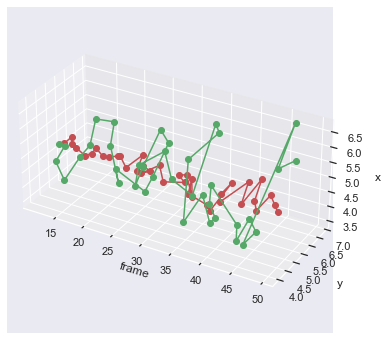

In [71]:
from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure(figsize=(20,10))
fig = plt.figure(figsize=plt.figaspect(1)*1.5)
ax = fig.add_subplot(111, projection='3d')
ts = features['frame'].values
ys = features['y'].values
xs = features['x'].values
ax.plot(ts, ys, xs, c='r', marker='o')
ts = features_trnl['frame'].values
ys = features_trnl['y'].values
xs = features_trnl['x'].values
ax.plot(ts, ys, xs, c='g', marker='o')
ax.set_box_aspect((7, 3, 3))  # aspect ratio is 1:1:1 in data space
ax.set_xlabel('frame')
ax.set_ylabel('y')
ax.set_zlabel('x')
plt.show()

In [ ]:
# # Possible code to make a bandpass filter to exactly match what we did in mathematica. 
# # In principle should be the same as the difference_of_gaussians() command I'm currently using.
# # make a get_intensity function
# # make a save tif function
# original_grayscale = numpy.asarray(some_PIL_image.convert('L'), dtype=float)
# blurred_grayscale = scipy.ndimage.filters.gaussian_filter(original_grayscale, blur_parameter)
# difference_image = original_grayscale - (multiplier * blurred_grayscale);
# image_to_be_labeled = ((difference_image > threshold) * 255).astype('uint8')  # not sure if it is necessary

# labelarray, particle_count = scipy.ndimage.measurements.label(image_to_be_labeled)

### Testing random stuff

In [ ]:
#del sys.modules['trackArrayTools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
from trackArrayTools import *
ta = TrackArray(track_array_vid, track_array_df, crop_pad)

In [ ]:
smart_z=ta.mask_projection(ta.to_crop_array(ta.z_masks(1,0)))

You can get back individual crops after doing a smart-z projection using the array_to_crops(arr) function. With this, when you max project, you see kymographs, which is nice.

In [ ]:
ta.napari_viewer(array_to_crops(smart_z),[1,1],int_range = ta.int_range(0.1,8))

Now you can average over t to get crops, as Luis did in his code. 

In [ ]:
ta.napari_viewer(np.hstack(np.mean(array_to_crops(smart_z),axis=1)),[1,1],int_range = ta.int_range(0.1,8))